In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.layers as layers

In [3]:
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                              as_supervised=True)

In [4]:
train_examples, val_examples = examples['train'], examples['validation']

In [6]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
(en.numpy() for pt, en in train_examples), target_vocab_size=2**13)
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
(pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [7]:
MAX_LENGTH=40
def filter_long_sent(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                         tf.size(y) <= max_length)

In [8]:
def tf_encode(pt, en):
    return tf.py_function(encode, [pt, en], [tf.int64, tf.int64])

In [9]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
        lang1.numpy()) + [tokenizer_pt.vocab_size+1]
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        lang2.numpy()) + [tokenizer_en.vocab_size+1]
    return lang1, lang2

In [10]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

# 使用.map()运行相关图操作
train_dataset = train_examples.map(tf_encode)
# 过滤过长的数据
train_dataset = train_dataset.filter(filter_long_sent)
# 使用缓存数据加速读入
train_dataset = train_dataset.cache()
# 打乱并获取批数据
train_dataset = train_dataset.padded_batch(
BATCH_SIZE, padded_shapes=([40], [40]))  # 填充为最大长度-90
# 设置预取数据
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 验证集数据
val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_long_sent).padded_batch(
BATCH_SIZE, padded_shapes=([40], [40]))

In [14]:
np.arange(2)[:, np.newaxis]

array([[0],
       [1]])

In [46]:
def positional_encoding(position, d_model):
    position_matrix = np.zeros((position, d_model))
    for p in range(position):
        for j in range(d_model):
            if j % 2 == 0:
                position_matrix[p][j] = np.sin(p/np.power(10000, 2*(j//2)/np.float32(d_model)))
            else:
                position_matrix[p][j] = np.cos(p/np.power(10000, 2*(j//2)/np.float32(d_model)))
                
    position_matrix = position_matrix[np.newaxis, ...]           
    
    return tf.cast(position_matrix, dtype=tf.float32)
    

In [29]:
def get_angles(pos, i, d_model):
    # 这里的i等价与上面公式中的2i和2i+1
    angle_rates = 1 / np.power(10000, (2*(i // 2))/ np.float32(d_model))
    return pos * angle_rates

def positional_encoding1(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis,:],
                           d_model)
    # 第2i项使用sin
    sines = np.sin(angle_rads[:, 0::2])
    # 第2i+1项使用cos
    cones = np.cos(angle_rads[:, 1::2])
    print(sines.shape)
    pos_encoding = np.concatenate([sines, cones], axis=-1)
    print(pos_encoding.shape)
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [30]:
positional_encoding1(2, 2)

(2, 1)
(2, 2)


<tf.Tensor: id=207419, shape=(1, 2, 2), dtype=float32, numpy=
array([[[0.        , 1.        ],
        [0.84147096, 0.5403023 ]]], dtype=float32)>

In [34]:
position_encoding(2, 2)

array([[[0.        , 1.        ],
        [0.84147098, 0.54030231]]])

In [90]:
k = tf.constant([[2, 3, 4], [3, 4, 5]], dtype=tf.float32)
a = tf.cast(tf.shape(k)[-1], tf.float32)
tf.sqrt(a)

<tf.Tensor: shape=(), dtype=float32, numpy=1.7320508>

In [91]:
def scala_dot_product_attention(q, k, v, mask):
    matmual_k = tf.matmul(q, k, transpose_b=True)
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmual_k/tf.sqrt(dk)
    
    attention_weight = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    
    output = tf.matmul(attention_weight, v)
    
    return output, attention_weight
    
    

In [93]:
q = tf.constant([[1, 2, 3], [2, 3, 4]], dtype=tf.float32)
k = tf.constant([[2, 3, 4], [3, 4, 5]], dtype=tf.float32)
v = tf.constant([[3, 4, 5], [4, 5, 6]], dtype=tf.float32)

In [94]:
scala_dot_product_attention(q, k, v, None)

(<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[3.9696488, 4.969649 , 5.969649 ],
        [3.9944925, 4.9944925, 5.994493 ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.03035108, 0.9696489 ],
        [0.00550734, 0.99449265]], dtype=float32)>)

In [ ]:
attention_size = 10

In [85]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        # d_model 必须可以正确分为各个头
        assert d_model % num_heads == 0
        # 分头后的维度
        self.depth = d_model // num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        # 分头, 将头个数的维度 放到 seq_len 前面
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        # 分头前的前向网络，获取q、k、v语义
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)
        v = self.wv(v)
        
        # 分头
        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_v, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        
        # 通过缩放点积注意力层
        scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
        # 把多头维度后移
        scaled_attention = tf.transpose(scaled_attention, [0, 2, 1, 3]) # (batch_size, seq_len_v, num_heads, depth)

        # 合并多头
        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))
        
        # 全连接重塑
        output = self.dense(concat_attention)
        return output, attention_weights
        
    

In [17]:
temp_mha = MultiHeadAttention(d_model=512, d_head=8)
y = tf.random.uniform((1, 60, 512))
output, att = temp_mha(y, y, y, mask=None)
print(output.shape, att.shape)

(1, 60, 512) (1, 8, 60, 60)


In [32]:
def point_wise_feed_forward_network(d_model, diff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(diff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [33]:
sample_fnn = point_wise_feed_forward_network(512, 2048)
sample_fnn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [34]:
class LayerNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-6, **kwargs):
        self.eps = epsilon
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=tf.ones_initializer(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=tf.zeros_initializer(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = tf.keras.backend.mean(x, axis=-1, keepdims=True)
        std = tf.keras.backend.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

In [35]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, ddf, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ffn = point_wise_feed_forward_network(d_model, ddf)
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, inputs, training, mask):
        # 多头注意力网络
        att_output, _ = self.mha(inputs, inputs, inputs, mask)
        att_output = self.dropout1(att_output, training=training)
        out1 = self.layernorm1(inputs + att_output)  # (batch_size, input_seq_len, d_model)
        # 前向网络
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2

In [36]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_encoder_layer_output = sample_encoder_layer(
tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

In [37]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, drop_rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(drop_rate)
        self.dropout2 = layers.Dropout(drop_rate)
        self.dropout3 = layers.Dropout(drop_rate)
        
    def call(self,inputs, encode_out, training, 
             look_ahead_mask, padding_mask):
        # masked muti-head attention
        att1, att_weight1 = self.mha1(inputs, inputs, inputs,look_ahead_mask)
        att1 = self.dropout1(att1, training=training)
        out1 = self.layernorm1(inputs + att1)
        # muti-head attention
        att2, att_weight2 = self.mha2(encode_out, encode_out, inputs, padding_mask)
        att2 = self.dropout2(att2, training=training)
        out2 = self.layernorm2(out1 + att2)
        
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out, training=training)
        out3 = self.layernorm3(out2 + ffn_out)
        
        return out3, att_weight1, att_weight2

In [38]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)
sample_decoder_layer_output.shape

TensorShape([64, 50, 512])

In [48]:
class Encoder(layers.Layer):
    def __init__(self, n_layers, d_model, n_heads, ddf,
                input_vocab_size, max_seq_len, drop_rate=0.1):
        super(Encoder, self).__init__()
        
        self.n_layers = n_layers
        self.d_model = d_model
        
        self.embedding = layers.Embedding(input_vocab_size, d_model)
        self.pos_embedding = positional_encoding(max_seq_len, d_model)
        
        self.encode_layer = [EncoderLayer(d_model, n_heads, ddf, drop_rate)
                            for _ in range(n_layers)]
        
        self.dropout = layers.Dropout(drop_rate)
    def call(self, inputs, training, mark):
        
        seq_len = inputs.shape[1]
        word_emb = self.embedding(inputs)
        word_emb *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        emb = word_emb + self.pos_embedding[:,:seq_len,:]
        x = self.dropout(emb, training=training)
        for i in range(self.n_layers):
            x = self.encode_layer[i](x, training, mark)
        
        return x

In [49]:
sample_encoder = Encoder(2, 512, 8, 1024, 5000, 200)
sample_encoder_output = sample_encoder(tf.random.uniform((64, 120)),
                                      False, None)
sample_encoder_output.shape

TensorShape([64, 120, 512])

In [44]:
class Decoder(layers.Layer):
    def __init__(self, n_layers, d_model, n_heads, ddf,
                target_vocab_size, max_seq_len, drop_rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.n_layers = n_layers
        
        self.embedding = layers.Embedding(target_vocab_size, d_model)
        self.pos_embedding = positional_encoding(max_seq_len, d_model)
        
        self.decoder_layers= [DecoderLayer(d_model, n_heads, ddf, drop_rate)
                             for _ in range(n_layers)]
        
        self.dropout = layers.Dropout(drop_rate)
        
    def call(self, inputs, encoder_out,training,
             look_ahead_mark, padding_mark):
    
        seq_len = tf.shape(inputs)[1]
        attention_weights = {}
        h = self.embedding(inputs)
        h *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        h += self.pos_embedding[:,:seq_len,:]
        
        h = self.dropout(h, training=training)
#         print('--------------------\n',h, h.shape)
        # 叠加解码层
        for i in range(self.n_layers):
            h, att_w1, att_w2 = self.decoder_layers[i](h, encoder_out,
                                                   training, look_ahead_mark,
                                                   padding_mark)
            attention_weights['decoder_layer{}_att_w1'.format(i+1)] = att_w1
            attention_weights['decoder_layer{}_att_w2'.format(i+1)] = att_w2
        
        return h, attention_weights

In [50]:
sample_decoder = Decoder(2, 512,8,1024,5000, 200)
sample_decoder_output, attn = sample_decoder(tf.random.uniform((64, 100)),
                                            sample_encoder_output, False,
                                            None, None)
sample_decoder_output.shape, attn['decoder_layer1_att_w1'].shape

(TensorShape([64, 100, 512]), TensorShape([64, 8, 100, 100]))

In [51]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, diff,
                input_vocab_size, target_vocab_size,
                max_seq_len, drop_rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(n_layers, d_model, n_heads,diff,
                              input_vocab_size, max_seq_len, drop_rate)
        
        self.decoder = Decoder(n_layers, d_model, n_heads, diff,
                              target_vocab_size, max_seq_len, drop_rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    def call(self, inputs, targets, training, encode_padding_mask, 
            look_ahead_mask, decode_padding_mask):
        
        encode_out = self.encoder(inputs, training, encode_padding_mask)
        print(encode_out.shape)
        decode_out, att_weights = self.decoder(targets, encode_out, training, 
                                               look_ahead_mask, decode_padding_mask)
        print(decode_out.shape)
        final_out = self.final_layer(decode_out)
        
        return final_out, att_weights

In [52]:
sample_transformer = Transformer(
n_layers=2, d_model=512, n_heads=8, diff=1024,
input_vocab_size=8500, target_vocab_size=8000, max_seq_len=120
)
temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))
fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                              encode_padding_mask=None,
                               look_ahead_mask=None,
                               decode_padding_mask=None,
                              )
fn_out.shape

(64, 62, 512)
(64, 26, 512)


TensorShape([64, 26, 8000])

In [54]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                              as_supervised=True)

In [55]:
train_examples, val_examples = examples['train'], examples['validation']

In [56]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
(en.numpy() for pt, en in train_examples), target_vocab_size=2**13)
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
(pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [57]:
MAX_LENGTH=40
def filter_long_sent(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                         tf.size(y) <= max_length)

In [58]:
def tf_encode(pt, en):
    return tf.py_function(encode, [pt, en], [tf.int64, tf.int64])

In [60]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
        lang1.numpy()) + [tokenizer_pt.vocab_size+1]
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        lang2.numpy()) + [tokenizer_en.vocab_size+1]
    return lang1, lang2

In [61]:
for x, y in train_examples:
    print(x)
    print(y)
    x, y = encode(x, y)
    print(x)
    print(y)
    break

tf.Tensor(b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .', shape=(), dtype=string)
tf.Tensor(b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .', shape=(), dtype=string)
[8214, 6, 40, 4092, 57, 3, 1687, 1, 6155, 12, 3, 461, 6770, 19, 5227, 1088, 97, 1, 5, 8, 3, 4213, 3408, 7256, 1670, 2, 8215]
[8087, 4, 59, 15, 1792, 6561, 3060, 7952, 1, 15, 103, 134, 378, 3, 47, 6122, 6, 5311, 1, 91, 13, 1849, 559, 1609, 894, 2, 8088]


In [62]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

# 使用.map()运行相关图操作
train_dataset = train_examples.map(tf_encode)
# 过滤过长的数据
train_dataset = train_dataset.filter(filter_long_sent)
# 使用缓存数据加速读入
train_dataset = train_dataset.cache()
# 打乱并获取批数据
train_dataset = train_dataset.padded_batch(
BATCH_SIZE, padded_shapes=([40], [40]))  # 填充为最大长度-90
# 设置预取数据
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 验证集数据
val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_long_sent).padded_batch(
BATCH_SIZE, padded_shapes=([40], [40]))

In [63]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
max_seq_len = 40
dropout_rate = 0.1

In [64]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [65]:
learing_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learing_rate, beta_1=0.9, 
                                    beta_2=0.98, epsilon=1e-9)

Text(0, 0.5, 'train step')

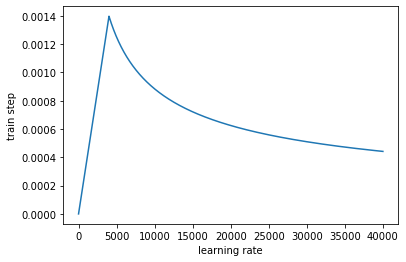

In [66]:
# 测试
temp_learing_rate = CustomSchedule(d_model)
plt.plot(temp_learing_rate(tf.range(40000, dtype=tf.float32)))
plt.xlabel('learning rate')
plt.ylabel('train step')

In [67]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                           reduction='none')

def loss_fun(y_ture, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_ture, 0))  # 为0掩码标1
    loss_ = loss_object(y_ture, y_pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [68]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [82]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          max_seq_len, dropout_rate)

In [70]:
# 构建掩码
def create_mask(inputs,targets):
    encode_padding_mask = create_padding_mark(inputs)
    # 这个掩码用于掩输入解码层第二层的编码层输出
    decode_padding_mask = create_padding_mark(inputs)
    
    # look_ahead 掩码， 掩掉未预测的词
    look_ahead_mask = create_look_ahead_mark(tf.shape(targets)[1])
    # 解码层第一层得到padding掩码
    decode_targets_padding_mask = create_padding_mark(targets)
    
    # 合并解码层第一层掩码
    combine_mask = tf.maximum(decode_targets_padding_mask, look_ahead_mask)
    
    return encode_padding_mask, combine_mask, decode_padding_mask

In [80]:
checkpoint_path = './checkpoint/train'
ckpt = tf.train.Checkpoint(transformer=transformer,
                          optimizer=optimizer)
# ckpt管理器
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('last checkpoit restore')

last checkpoit restore


In [96]:
@tf.function
def train_step(inputs, targets):
    tar_inp = targets[:,:-1]
    tar_real = targets[:,1:]
    # 构造掩码
    encode_padding_mask, combined_mask, decode_padding_mask = create_mask(inputs, tar_inp)
    
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inputs, tar_inp,
                                    True,
                                    encode_padding_mask,
                                    combined_mask,
                                    decode_padding_mask)
        loss = loss_fun(tar_real, predictions)
    # 求梯度
    gradients = tape.gradient(loss, transformer.trainable_variables)
    # 反向传播
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    # 记录loss和准确率
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [75]:
def create_padding_mark(seq):
    # 获取为0的padding项
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # 扩充维度以便用于attention矩阵
    return seq[:, np.newaxis, np.newaxis, :] # (batch_size,1,1,seq_len)

# mark 测试
create_padding_mark([[1,2,0,0,3],[3,4,5,0,0]])

<tf.Tensor: shape=(2, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]]], dtype=float32)>

In [76]:
def create_look_ahead_mark(size):
    # 1 - 对角线和取下三角的全部对角线（-1->全部）
    # 这样就可以构造出每个时刻未预测token的掩码
    mark = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mark  # (seq_len, seq_len)

In [73]:
import time

In [ ]:
EPOCHS = 20
for epoch in range(EPOCHS):
    start = time.time()
    
    # 重置记录项
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    # inputs 葡萄牙语， targets英语
    
    for batch, (inputs, targets) in enumerate(train_dataset):
        # 训练
        train_step(inputs, targets)
        
        if batch % 500 == 0:
            print('epoch {}, batch {}, loss:{:.4f}, acc:{:.4f}'.format(
            epoch+1, batch, train_loss.result(), train_accuracy.result()
            ))
            
#     if (epoch + 1) % 2 == 0:
#         ckpt_save_path = ckpt_manager.save()
#         print('epoch {}, save model at {}'.format(
#         epoch+1, ckpt_save_path
#         ))
    
    
    print('epoch {}, loss:{:.4f}, acc:{:.4f}'.format(
    epoch+1, train_loss.result(), train_accuracy.result()
    ))
    
    print('time in 1 epoch:{} secs\n'.format(time.time()-start))

(64, 40, 128)
(64, 39, 128)
(64, 40, 128)
(64, 39, 128)
epoch 1, batch 0, loss:3.6506, acc:0.0000
epoch 1, batch 500, loss:2.6984, acc:0.0592
(31, 40, 128)
(31, 39, 128)
epoch 1, loss:2.4515, acc:0.0956
time in 1 epoch:820.1156380176544 secs

epoch 2, batch 0, loss:1.2324, acc:0.2280
epoch 2, batch 500, loss:0.9284, acc:0.3113
epoch 2, loss:0.8000, acc:0.3304
time in 1 epoch:791.5252058506012 secs

epoch 3, batch 0, loss:0.3320, acc:0.3562
epoch 3, batch 500, loss:0.2521, acc:0.4142
epoch 3, loss:0.2140, acc:0.4211
time in 1 epoch:748.6557490825653 secs

epoch 4, batch 0, loss:0.0842, acc:0.3970
epoch 4, batch 500, loss:0.0568, acc:0.4437
epoch 4, loss:0.0488, acc:0.4450
time in 1 epoch:764.3711895942688 secs

epoch 5, batch 0, loss:0.0274, acc:0.4026
epoch 5, batch 500, loss:0.0190, acc:0.4462
epoch 5, loss:0.0175, acc:0.4471
time in 1 epoch:744.6127412319183 secs

epoch 6, batch 0, loss:0.0090, acc:0.4046
epoch 6, batch 500, loss:0.0117, acc:0.4466
epoch 6, loss:0.0115, acc:0.4474
ti